# ** Insurance Claim Costs Prediction **
#### Saeideh Kamgarsangari 
##### October 2024<br><br>



## **Table of Contents**
1. [Business Problem](#Business-Problem)
2. [Data Issues and Resolutions](#Data-Issues-and-Resolutions)
3. [Data Cleansing Process](#Data-Cleansing-Process)
4. [Model Specification and Justification](#Model-Specification-and-Justification)
5. [Model Accuracy and Diagnostics](#Model-Accuracy-and-Diagnostics)
6. [Suggestions for Model Improvement](#Suggestions-for-Model-Improvement)
7. [Practical Challenges in Model Implementation](#Practical-Challenges-in-Model-Implementation)




## **Business Problem**

#### Objective:
- **Develop a model** predict the **Claims Costs** using XGBoost with sample weights.  
  
#### Dataset:
- **Type of Claim**: Historical dataset focused on head-on collisions.
- **Available Data**: **FNOL characteristics** and **Incurred values** 


## **Data Issues and Resolutions**

- First we import the dependencies



In [5]:
# Import the dependencies
"""
Author: Saeideh Kamgar [saeideh.kamgar@gmail.com]
Date: 20 Oct 2024
"""
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
import pickle
import os
from scipy.special import inv_boxcox

In [6]:
# Parameters definition

trans_method = 'log'  # type of transformation to be applied to the target to deal with skewnewss of the data option available are: log, Box-Cox, none).
verbose = False  # Set this to True to enable detailed print statements for debugging/logging purposes.
threshold_target_value = 0.975  # If target is skewed, define a threshold for capping the target (e.g., 99th percentile)
decay_func= True #if we use exponential decay function for recent and older claims
split_test_size = 0.33  # This defines the size of the test set as a subsample of the overall dataset. 
                 # (1-split_test_size) % of the data will be used for training.


#### **Read and Understand the Data**
- The data dimensions are : (7691, 46)
- The data includes information of 7691 claims with 46 features 

- Features includes two features with float64 type, 35 features with int64, and 9 features with object type

- The feature (Weather_conditions) has missing values.

- Some columns have negative values.

#### Please update the working directory in the following cell.


In [8]:
#Data Preview
def data_io(working_path, data_name, sheet_name = 'Data', verbose = False):
    """
    Load and prepare the data from an Excel file, ensuring necessary directories are created, 
    and checks are performed to avoid errors during file access.

    Parameters:
    - working_path (str): The main working directory path.
    - data_name (str): The name of the Excel file to be loaded.
    - sheet_name (str): The name of the sheet in the Excel file. Default is 'Data'.
    - verbose (bool): If True, prints dataset shape, column info, and summary statistics. Default is False.
    
    Returns:
    - df_cleaned (pd.DataFrame): The cleaned and loaded DataFrame from the Excel file.
    """

    # Check if the working directory exists to prevent any errors while accessing files.
    assert Path(working_path).is_dir(), f"No {working_path} directory exists!"

    # Define paths for data, model, and figures directories, ensuring they are created if they don't exist.
    data_path = Path(working_path) / "data"
    model_path = Path(working_path) / "model"
    fig_path = Path(working_path) / "figures"
    
    Path(data_path).mkdir(parents=True, exist_ok=True)
    Path(model_path).mkdir(parents=True, exist_ok=True)
    Path(fig_path).mkdir(parents=True, exist_ok=True)

    # Combine the working directory and file name to get the full path of the data file.
    data_file_path = data_path / data_name
    assert data_file_path.is_file(), f"No data file: {data_file_path}"  # Ensure the data file exists before proceeding.

    # Read the data from the Excel sheet.
    df_cleaned = pd.read_excel(data_file_path, sheet_name=sheet_name)  # Replace 'Data' if the sheet name differs.

    
    # Display basic information about the data if verbose is set to True.
    if verbose:
        print(df_cleaned.shape)  # Print the shape of the dataset (rows, columns)
        print(df_cleaned.info())  # Print data types and non-null counts for each column
        print(df_cleaned.describe())  # Print summary statistics for numerical columns

    return df_cleaned

# The following code block is used to load and prepare the data from an Excel file.

working_path = '/Users/saeideh/project'
data_name = 'Data_Scientist_Interview_Task.xlsx'

df_cleaned = data_io(working_path, data_name, verbose=False)


## **Data Cleansing Process**

#### Data Cleaning and Feature Engineering

 **Column Name Cleaning**:
   - Replaced spaces with underscores and capitalized the first letter.
   - Ensures consistency and ease of use in the dataset.

 **Column Filtering**:
   - Removed columns with only one unique value.
   - These columns provide no useful information for modeling.

 **Date Conversion**:
   - Converted 'Date_of_loss' to a **datetime** format for proper date handling and time-based calculations.

 **Feature Creation: Days_since_loss**:
   - Created a new feature to capture the number of days since the loss occurred.
   - Useful for modeling time effects.

 **Feature Scaling**:
   - Scaled 'Days_since_loss' between 0 and 1 using **Min-Max scaling**.
   - Standardizes values for models that require normalized inputs.

 **Cyclic Time Feature Creation**:
   - Applied **sine** and **cosine transformations** to 'Time_hour' to capture cyclic patterns.
   - Important for time-based features (e.g., the 24-hour cycle).



In [10]:
%%capture
#Data Preprocessing
def preprocess_dataset(df, verbose = False):
    """
    Preprocess the dataset by renaming columns, creating new features, and applying transformations.

    Parameters:
    - df (pd.DataFrame): The original dataset to preprocess.
    - verbose (bool): If True, prints detailed information about the dataset after preprocessing.

    Returns:
    - df (pd.DataFrame): The preprocessed dataset with renamed columns, transformed features, and scaled values.
    """
    # Create a copy of the dataframe to avoid SettingWithCopyWarning in jupyter notebook
    df = df.copy()
    
    # Rename dataset columns by replacing spaces with underscores and capitalizing the first letter of each column name
    df.columns = df.columns.str.replace(' ', '_')
    df.columns = df.columns.str.capitalize()

    # Drop columns with only one unique value
    df = df.loc[:, df.nunique() > 1]

    # Print data info if verbose is set to True
    if verbose:
        print(df.info())

    # Convert 'Date_of_loss' to datetime format for time-based analysis
    df['Date_of_loss'] = pd.to_datetime(df['Date_of_loss'], errors='coerce')

    # Create a new feature 'Days_since_loss' to represent the time (in days) since the loss occurred
    current_date = pd.Timestamp.today()
    df['Days_since_loss'] = (current_date - df['Date_of_loss']).dt.days

    # Drop the 'Date_of_loss' column after transformation
    df.drop(columns=['Date_of_loss'], inplace=True)

    # Initialize a MinMaxScaler to scale 'Days_since_loss' between 0 and 1
    scaler = MinMaxScaler()
    df['weight_Days_since_loss'] = scaler.fit_transform(df[['Days_since_loss']])

    # Drop the original 'Days_since_loss' column after scaling
    df.drop(columns=['Days_since_loss'], inplace=True)

    # Apply sine and cosine transformations to 'Time_hour' for its cyclic nature
    df['Sin_time_hour'] = (np.sin(2 * np.pi * df['Time_hour'] / 24) + 1) / 2
    df['Cos_time_hour'] = (np.cos(2 * np.pi * df['Time_hour'] / 24) + 1) / 2

    # Drop the original 'Time_hour' column after transformation
    df.drop(columns=['Time_hour'], inplace=True)

    return df

# runner:
df_cleaned = preprocess_dataset(df_cleaned, verbose=True)



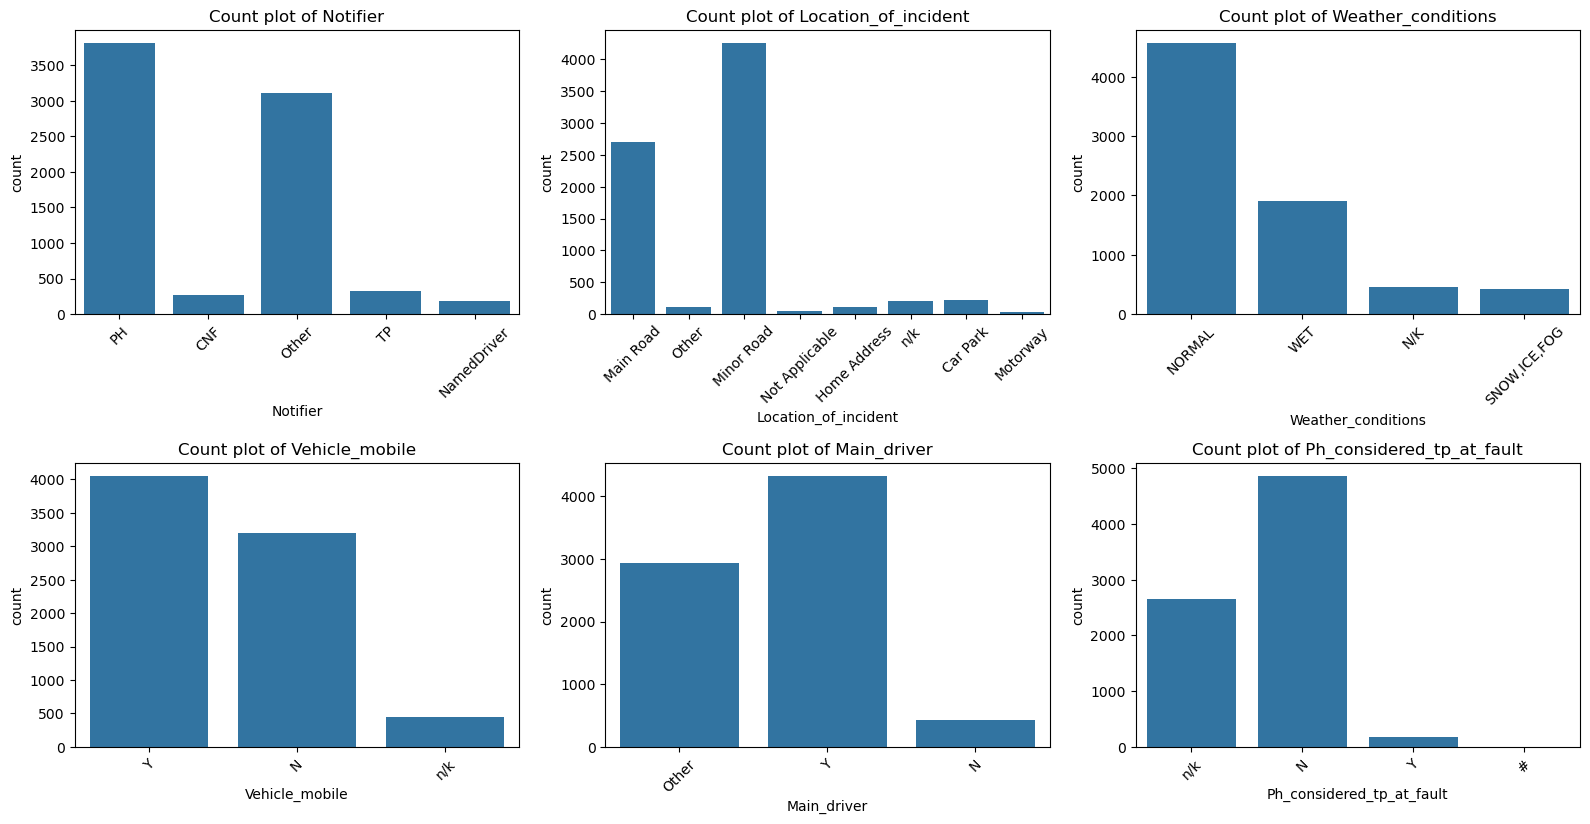

In [11]:
# Count plots of categitical columns
def plot_categorical_countplots(df, n_cols = 4):
    """
    Plot count plots for all categorical features in the dataset, arranged in a grid.

    Parameters:
    - df (pd.DataFrame): The cleaned dataset containing categorical columns to plot.
    - n_cols (int): The number of columns per row in the grid for plotting. Default is 4.

    Returns:
    - None. The function displays the count plots in a grid layout.
    """

    # Identify categorical columns
    categorical_features = df.select_dtypes(include=['object', 'category']).columns

    # Calculate number of rows required for the grid layout
    n_rows = int(len(categorical_features) / n_cols) + 1

    # Create a grid of subplots to plot the categorical count plots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4), sharey=False)

    # Flatten the axes for easier indexing
    axes = axes.flatten()

    # Plot count plots for each categorical variable
    for i, col in enumerate(categorical_features):
        sns.countplot(x=col, data=df, ax=axes[i])
        axes[i].set_title(f'Count plot of {col}')
        axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for readability

    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Optional example of hiding x-axis labels for one subplot (adjust based on your needs)
    if len(axes) > 6:
        axes[6].xaxis.set_visible(False)

    # Adjust layout to avoid overlapping
    plt.tight_layout()

    # Display the plots
    plt.show()

# runner:
plot_categorical_countplots(df_cleaned, n_cols=3)



#### Handling Missing Values in Categorical columns

1. **Identifying 'N/K' Values**:
   - Detected 'N/K' (Not Known) entries in multiple columns.
   - Replaced 'N/K' with **NaN** to ensure proper handling as missing data.

2. **Replacing 'N/K' with Meaningful Categories**:
   - In specific columns, replaced 'N/K' with a more interpretable category, such as **'Not-Known'**.
   - Improves the clarity and interpretability of the dataset for analysis.

3. **Filling Missing Values**:
   - Applied **mode imputation** (most frequent value) for categorical columns.
   - This preserves information, allowing models to be built without dropping rows due to missing data.


In [13]:
#Handling missing data in categorical features
def clean_and_fill_missing_values(df, verbose = False):
    """
    Clean and fill missing values in specific columns by replacing 'N/K' or variations, and filling NaN values 
    with the mode (most common value) in selected categorical columns.

    Parameters:
    - df (pd.DataFrame): The DataFrame to clean and process.
    - verbose (bool): If True, prints unique values of specified columns for verification.

    Returns:
    - df_cleaned_filled (pd.DataFrame): The cleaned DataFrame with missing values filled.
    """

    # List of columns where 'N/K' should be replaced with NaN
    columns_to_replace = ['Weather_conditions', 'Location_of_incident', 'Vehicle_mobile']

    # Replace 'N/K' (and case variations) with np.nan
    df[columns_to_replace] = df[columns_to_replace].replace(r'[nN]/[kK]', np.nan, regex=True)

    # Replace 'N/K' in 'Ph_considered_tp_at_fault' with a new category 'Not-Known'
    columns_to_newCategory = ['Ph_considered_tp_at_fault']
    df[columns_to_newCategory] = df[columns_to_newCategory].replace(r'[nN]/[kK]', 'Not-Known', regex=True)

    # Replace any '#' values in 'Ph_considered_tp_at_fault' with np.nan
    df['Ph_considered_tp_at_fault'] = df['Ph_considered_tp_at_fault'].replace('#', np.nan, regex=True)

    # Make a copy of the dataset for filling missing values
    df_cleaned_filled = df.copy()

    # List of columns where missing values will be filled with the mode
    missing_cat = ['Weather_conditions', 'Location_of_incident', 'Vehicle_mobile', 'Ph_considered_tp_at_fault']

    # Fill missing values in these categorical columns with the most common value (mode)
    df_cleaned_filled[missing_cat] = df_cleaned_filled[missing_cat].fillna(df_cleaned_filled[missing_cat].mode().iloc[0])

    return df_cleaned_filled

# runner:
df_cleaned_filled = clean_and_fill_missing_values(df_cleaned, verbose=True)

# runner:
if verbose:
    plot_categorical_countplots(df_cleaned_filled, n_cols = 3)

#### **Dropping Unnecessary Numerical Columns**

- Identified and visualised numerical features

- **Detected skewed distributions** in certain variables, which may impact model performance.

- **Drop unnecessary columns** that are either identifiers (e.g., **'Claim_number'**) or do not provide useful information for the model (e.g., 'Vechile_registration_present'**).


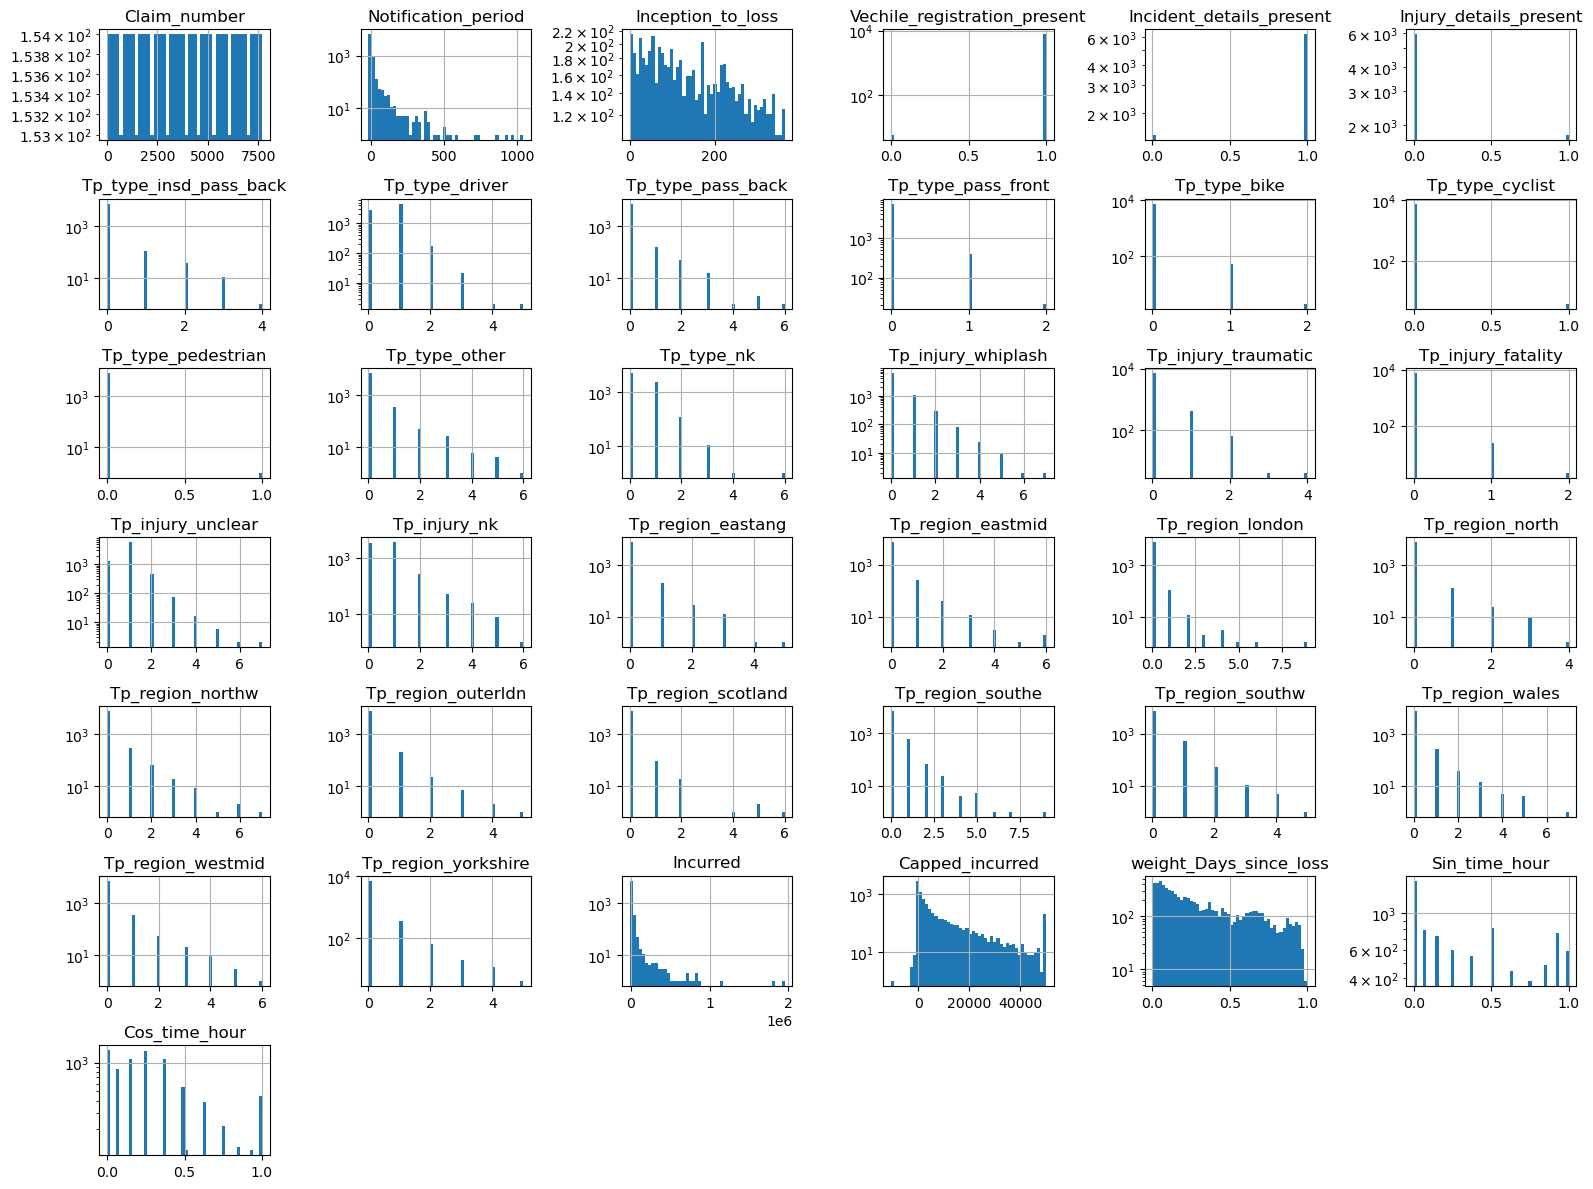

In [15]:
# Identified and visualised numerical features
def plot_numerical_histograms(df, log_scale = True, bins = 50):
    """
    Plot histograms for all numerical columns in the dataset, with an option to apply a log scale on the y-axis 
    to visualize skewed data.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - log_scale (bool): Whether to apply a log scale to the y-axis. Default is True.
    - bins (int): The number of bins for the histograms. Default is 50.

    Returns:
    - None. The function displays histograms of numerical columns.
    """

    # Get unique value counts for all columns to understand cardinality
    unique_counts = df.nunique()

    # Select only the numerical columns (float64 and int64 data types)
    numeric_vars = df.select_dtypes(include=['float64', 'int64']).columns

    # Plot histograms for the numerical variables
    df[numeric_vars].hist(bins=bins, figsize=(16, 12), log=log_scale)  # Use log scale for y-axis if specified

    # Adjust the layout of the plots to avoid overlap
    plt.tight_layout()

    # Display the plots
    plt.show()

# runner:
plot_numerical_histograms(df_cleaned_filled, log_scale=True, bins=50)




In [16]:
#Drop unnecessary columns
def drop_columns_and_update_numeric_vars(df, columns_to_drop, verbose = False):
    """
    Drop specified columns from the DataFrame and update the list of numeric variables.

    Parameters:
    - df (pd.DataFrame): The DataFrame from which columns will be dropped.
    - columns_to_drop (list): A list of columns to be removed from the DataFrame.
    - verbose (bool): If True, prints the updated list of numeric variables for verification.

    Returns:
    - df_cleaned (pd.DataFrame): The updated DataFrame with specified columns dropped.
    - numeric_vars_update (list): The updated list of numeric variables excluding the dropped columns.
    """

    # Make a copy of the DataFrame to avoid modifying the original dataset
    df_cleaned = df.copy()

    # Drop the specified columns from the DataFrame if they exist
    df_cleaned.drop(columns=[col for col in columns_to_drop if col in df_cleaned.columns], inplace=True)

    # Select only the numerical columns (float64 and int64 data types)
    numeric_vars = df_cleaned.select_dtypes(include=['float64', 'int64']).columns
    
    # Update the list of numeric variables by excluding the dropped columns
    numeric_vars_update = [col for col in numeric_vars if col not in columns_to_drop]

    # If verbose is set to True, print the updated list of numeric variables
    if verbose:
        print(numeric_vars_update)

    return df_cleaned, numeric_vars_update

# runner:
columns_to_drop = ['Claim_number', 'Vechile_registration_present', 'Tp_type_cyclist', 'Tp_type_pedestrian']
df_cleaned, numeric_vars_update = drop_columns_and_update_numeric_vars(df_cleaned_filled, columns_to_drop, verbose=True)



['Notification_period', 'Inception_to_loss', 'Incident_details_present', 'Injury_details_present', 'Tp_type_insd_pass_back', 'Tp_type_driver', 'Tp_type_pass_back', 'Tp_type_pass_front', 'Tp_type_bike', 'Tp_type_other', 'Tp_type_nk', 'Tp_injury_whiplash', 'Tp_injury_traumatic', 'Tp_injury_fatality', 'Tp_injury_unclear', 'Tp_injury_nk', 'Tp_region_eastang', 'Tp_region_eastmid', 'Tp_region_london', 'Tp_region_north', 'Tp_region_northw', 'Tp_region_outerldn', 'Tp_region_scotland', 'Tp_region_southe', 'Tp_region_southw', 'Tp_region_wales', 'Tp_region_westmid', 'Tp_region_yorkshire', 'Incurred', 'Capped_incurred', 'weight_Days_since_loss', 'Sin_time_hour', 'Cos_time_hour']


#### **Handling Missing Data, Negative Values, and Outliers in Numerical columns**

- **Fill missing values** in numerical columns using the median, as a robust approach to handles skewed distributions.
- Identify and remove rows with unreasonable values, such as **negative values** in columns where they don’t make sense (e.g., time or financial data).
- Drop **columns with only one unique value**, as these columns don’t provide meaningful information for modeling.
- **Handle outliers** by capping extreme values


Missing values count after filling: Notifier                     0
Notification_period          0
Inception_to_loss            0
Location_of_incident         0
Weather_conditions           0
Vehicle_mobile               0
Main_driver                  0
Ph_considered_tp_at_fault    0
Incident_details_present     0
Injury_details_present       0
Tp_type_insd_pass_back       0
Tp_type_driver               0
Tp_type_pass_back            0
Tp_type_pass_front           0
Tp_type_bike                 0
Tp_type_other                0
Tp_type_nk                   0
Tp_injury_whiplash           0
Tp_injury_traumatic          0
Tp_injury_fatality           0
Tp_injury_unclear            0
Tp_injury_nk                 0
Tp_region_eastang            0
Tp_region_eastmid            0
Tp_region_london             0
Tp_region_north              0
Tp_region_northw             0
Tp_region_outerldn           0
Tp_region_scotland           0
Tp_region_southe             0
Tp_region_southw             0
Tp_

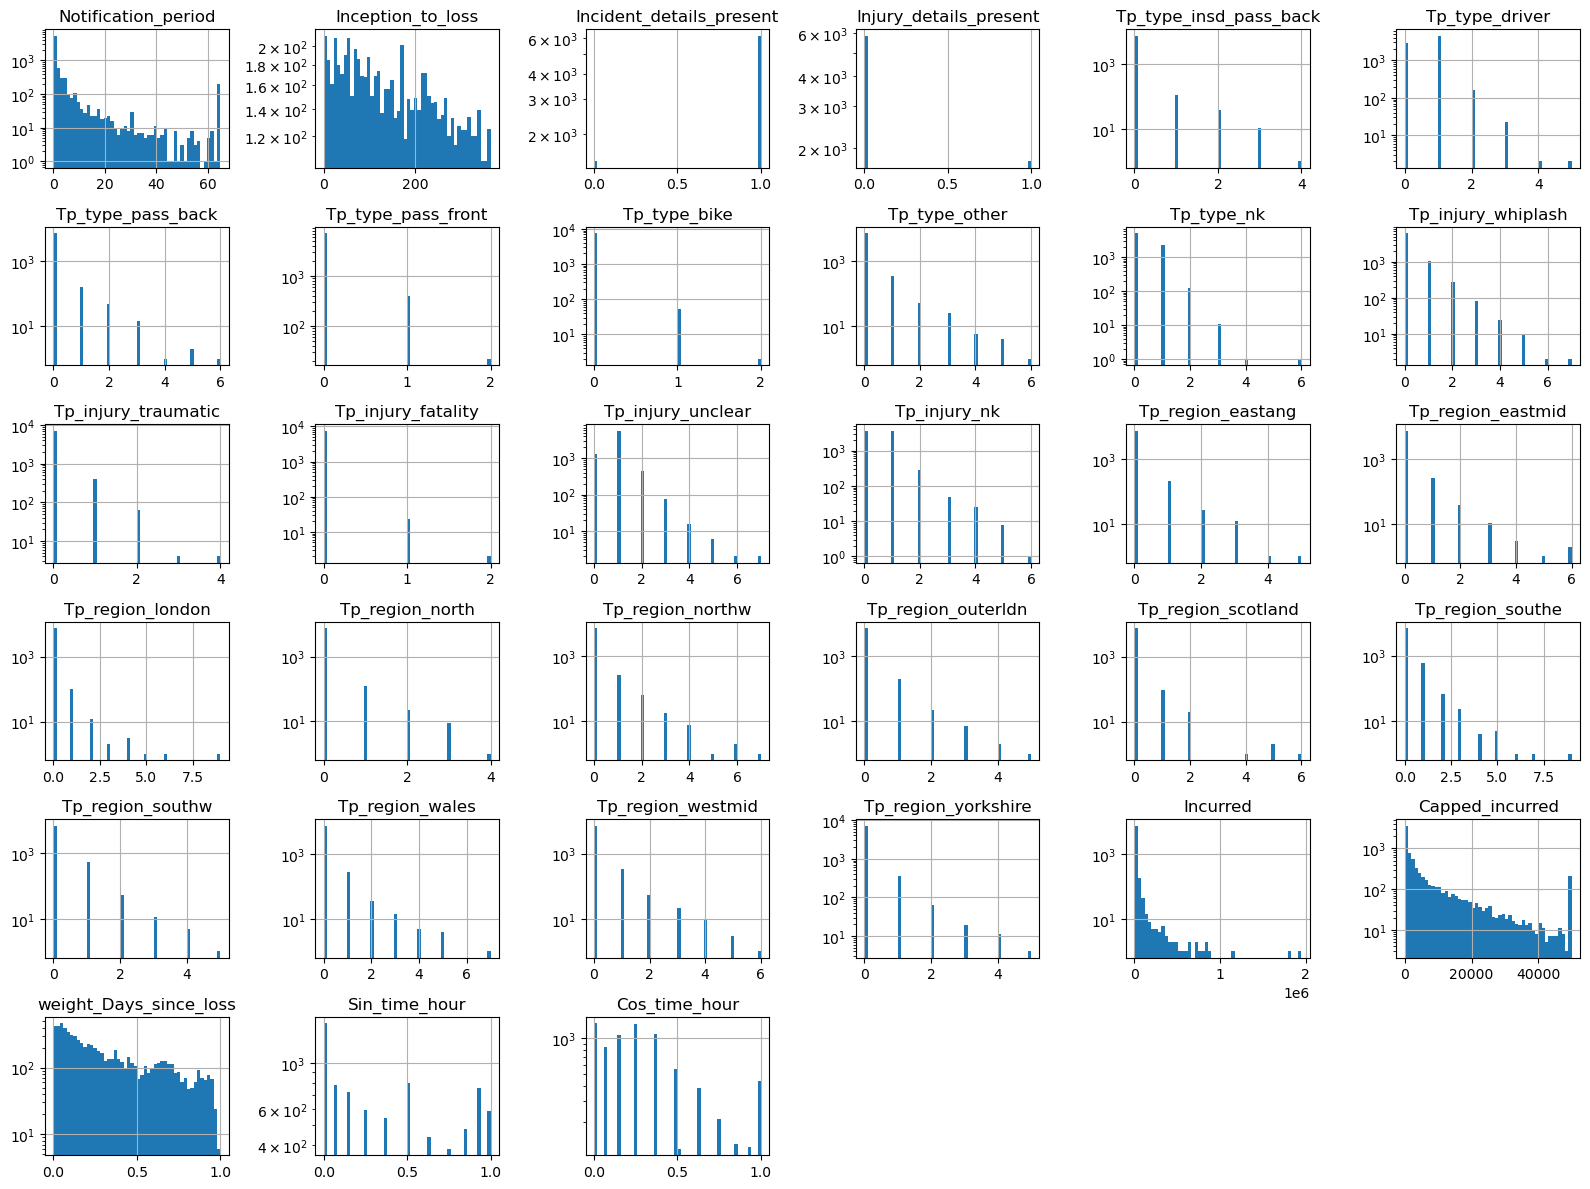

In [18]:
#clean numerical columns
def clean_numerical_data(df, numeric_vars, verbose= False, plot=True):
    """
    Clean numerical data by filling missing values, removing unreasonable negative values, and handling outliers.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing numerical data to clean.
    - numeric_vars (list): A list of numerical columns to be processed.
    - verbose (bool): If True, prints missing values count and negative value information for verification.

    Returns:
    - df_cleaned (pd.DataFrame): The cleaned DataFrame with missing values filled, negative values handled, and outliers capped.
    """

    # Make a copy of the DataFrame to avoid modifying the original dataset
    df_cleaned = df.copy()

    # Fill missing values in numerical columns with their median value
    df_cleaned[numeric_vars] = df_cleaned[numeric_vars].fillna(df_cleaned[numeric_vars].median())

    # If verbose is set to True, print the count of missing values in each column
    if verbose:
        print("Missing values count after filling:", df_cleaned.isnull().sum())

    # Identify numeric columns that contain negative values
    negative_columns = df_cleaned[numeric_vars].columns[(df_cleaned[numeric_vars] < 0).any()].tolist()

    # Count how many negative values exist in each identified column
    negative_counts = (df_cleaned[negative_columns] < 0).sum()

    # Define a threshold to decide which negative values should be removed
    threshold = 0.01 * len(df_cleaned)

    # Identify columns where the number of negative values is within the threshold
    columns_to_clean = negative_counts[negative_counts <= threshold].index.tolist()

    # Remove rows with negative values in the identified columns
    for col in columns_to_clean:
        df_cleaned = df_cleaned[df_cleaned[col] >= 0]

    # Reset the index after removing rows to avoid gaps in the index
    df_cleaned.reset_index(drop=True, inplace=True)

    # Drop columns with only one unique value
    unique_counts = df_cleaned.nunique()
    columns_to_drop = unique_counts[unique_counts <= 1].index
    df_cleaned = df_cleaned.drop(columns=columns_to_drop)

    # Handling outliers by capping values above the 99th percentile for 'Notification_period'
    if 'Notification_period' in df_cleaned.columns:
        upper_threshold = df_cleaned['Notification_period'].quantile(0.975)
        df_cleaned['Notification_period'] = np.where(df_cleaned['Notification_period'] > upper_threshold, upper_threshold, df_cleaned['Notification_period'])

    # If verbose is set to True, print the columns that were cleaned for negative values
    if verbose:
        print("Negative value columns cleaned:", columns_to_clean)

    if plot:
        # Visualize the distribution of numerical variables after cleaning
        df_cleaned[numeric_vars].hist(bins=50, figsize=(16, 12), log=True)
        plt.tight_layout()
        plt.show()

    return df_cleaned


# runner:
df_cleaned = clean_numerical_data(df_cleaned, numeric_vars_update, verbose=False, plot=True)



#### Target variabel
- Detect **skewness in the target variable**
    
- We address the skewness in the target variable ('Incurred') by **capping extreme values** at a defined upper percentile threshold.

- **Visualize the distribution** of the target variable (Capped_incurred or Incurred_capped_Xp) using a histogram. 

In [20]:
#Create capped Target
def cap_incurred_column(df, threshold_target_value, numeric_vars_update, targets_to_drop=None):
    """
    Caps the 'Incurred' column in the DataFrame based on the given threshold and updates the list of numeric variables.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the 'Incurred' column.
    - threshold_target_value (float): The quantile value to use for capping the 'Incurred' column (e.g., 0.9 for 90th percentile).
    - numeric_vars_update (list): List of numeric columns that should be updated after dropping target columns.
    - targets_to_drop (list, optional): List of target columns to drop (e.g., 'Incurred', 'Capped_incurred'). If None, default targets will be used.

    Returns:
    - df (pd.DataFrame): The updated DataFrame with the capped 'Incurred' column and dropped target columns.
    - numeric_vars_update (list): The updated list of numeric variables excluding the dropped columns.
    """

    # Step 1: Calculate the upper threshold for the 'Incurred' column based on the given threshold value
    upper_threshold_target = df['Incurred'].quantile(threshold_target_value)

    # Step 2: Create a dynamic column name reflecting the threshold value (e.g., "Incurred_capped_975p")
    target_fname = f'Incurred_capped_{threshold_target_value * 100}p'

    # Step 3: Cap the 'Incurred' values using pandas' clip() method
    df[target_fname] = df['Incurred'].clip(upper=upper_threshold_target)

    # Step 4: Drop target columns ('Incurred', 'Capped_incurred') from the DataFrame if they exist
    if targets_to_drop is None:
        targets_to_drop = ['Incurred', 'Capped_incurred']  # Default columns to drop
    
    df.drop(columns=[col for col in targets_to_drop if col in df.columns], inplace=True)

    # Step 5: Update the list of numeric variables by excluding the dropped target columns
    numeric_vars_update = [col for col in numeric_vars_update if col not in targets_to_drop]

    return df, numeric_vars_update


# runner:
df_cleaned, numeric_vars_update = cap_incurred_column(df_cleaned, threshold_target_value, numeric_vars_update)


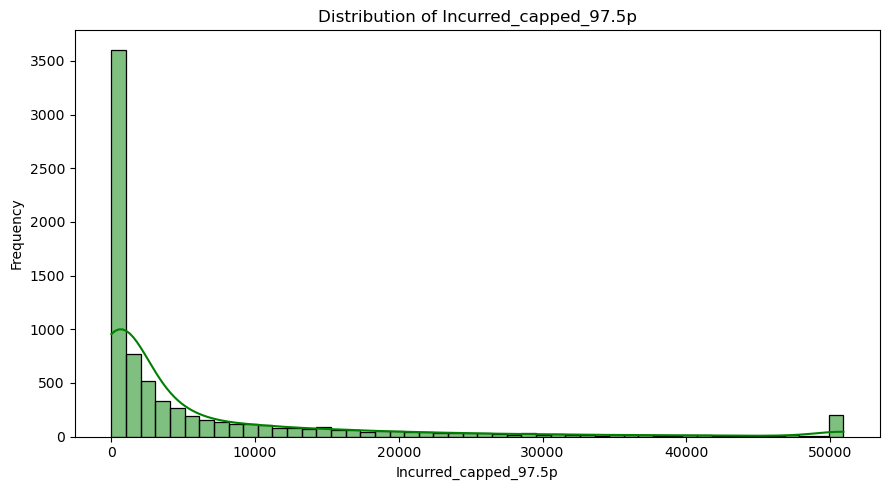

In [21]:
#Visualising Capped Target
def plot_target_distribution(df, target='Incurred_capped_97.5p', bins = 50):
    """
    Plot the distribution of the target variable using a histogram with KDE (Kernel Density Estimate).

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the target variable.
    - target (str): The name of the target variable to plot.
    - bins (int): The number of bins for the histogram. Default is 50.

    Returns:
    - None. The function displays the distribution plot.
    """

    # Set up the figure and plot
    plt.figure(figsize=(9, 5))
    plt.title(f'Distribution of {target}')

    # Plot the histogram with KDE for the target variable
    sns.histplot(df[target], color='g', kde=True, bins=bins)

    # Set x and y labels
    plt.xlabel(target)
    plt.ylabel('Frequency')

    # Show the plot
    plt.tight_layout()
    plt.show()

# runner:
plot_target_distribution(df_cleaned, target='Incurred_capped_97.5p', bins=50)

#### Correlation Matrix, Heatmap, and Scatter Plots for Numerical Features vs. Target

- Calculate the **correlation matrix** and provide **Heatmap**for numerical variables.
- Check **collinearity** by visualizing the correlation between features.
- Use **correlation matrix** and **scatter plots** to visualize and understand the **correlation between numerical features and target**.



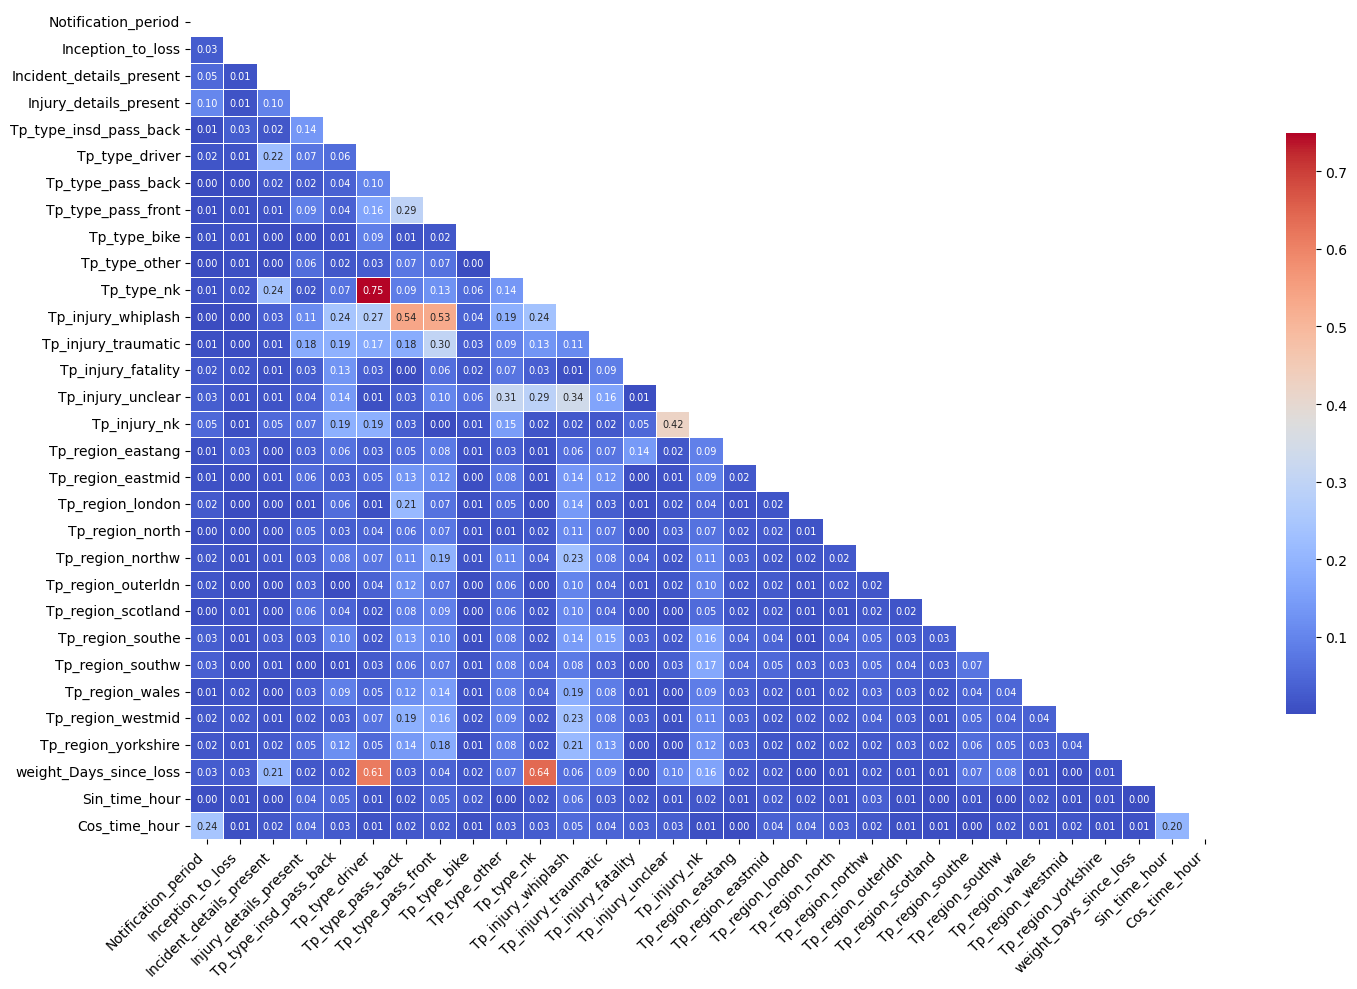

In [23]:
#Correlation heat map and Heatmap
def plot_correlation_heatmap(df, numeric_vars, target_var = 'Incurred_capped_97.5p', verbose = False):
    """
    Plot a correlation heatmap for numeric variables, improving readability for crowded plots.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the numeric variables.
    - numeric_vars (list): A list of numeric variables for which to calculate correlations.
    - target_var (str): The target variable for which correlations will be highlighted (default is 'Capped_incurred').
    - verbose (bool): If True, prints the correlations with the target variable in descending order.

    Returns:
    - corrMat. the correlation matrix of the numeric variables.
    """

    # Calculate the correlation matrix and take the absolute values
    corrMat = df[numeric_vars].corr().abs()

    # If verbose is enabled, print the correlations with the target variable sorted in descending order
    if verbose and target_var in corrMat.columns:
        print(f"Correlation with '{target_var}':")
        print(corrMat[target_var].sort_values(ascending=False))

    # Create a mask to hide the upper triangle of the correlation matrix (to reduce clutter)
    mask = np.triu(np.ones_like(corrMat, dtype=bool))

    # Set up the matplotlib figure
    plt.figure(figsize=(15, 10))

    # Generate a heatmap with smaller font size for annotations
    sns.heatmap(corrMat, mask=mask, annot=True, cmap="coolwarm", 
                cbar_kws={"shrink": 0.7}, linewidths=0.4, fmt=".2f", 
                annot_kws={"size": 7})  # Set font size for the annotations

    # Adjust the heatmap to improve readability
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.yticks(rotation=0)  # Keep y-axis labels horizontal

    # Show the plot
    plt.tight_layout()
    plt.show()
    return corrMat
# runner:
corrMat = plot_correlation_heatmap(df_cleaned, numeric_vars_update, target_var='Incurred_capped_97.5p', verbose=True)




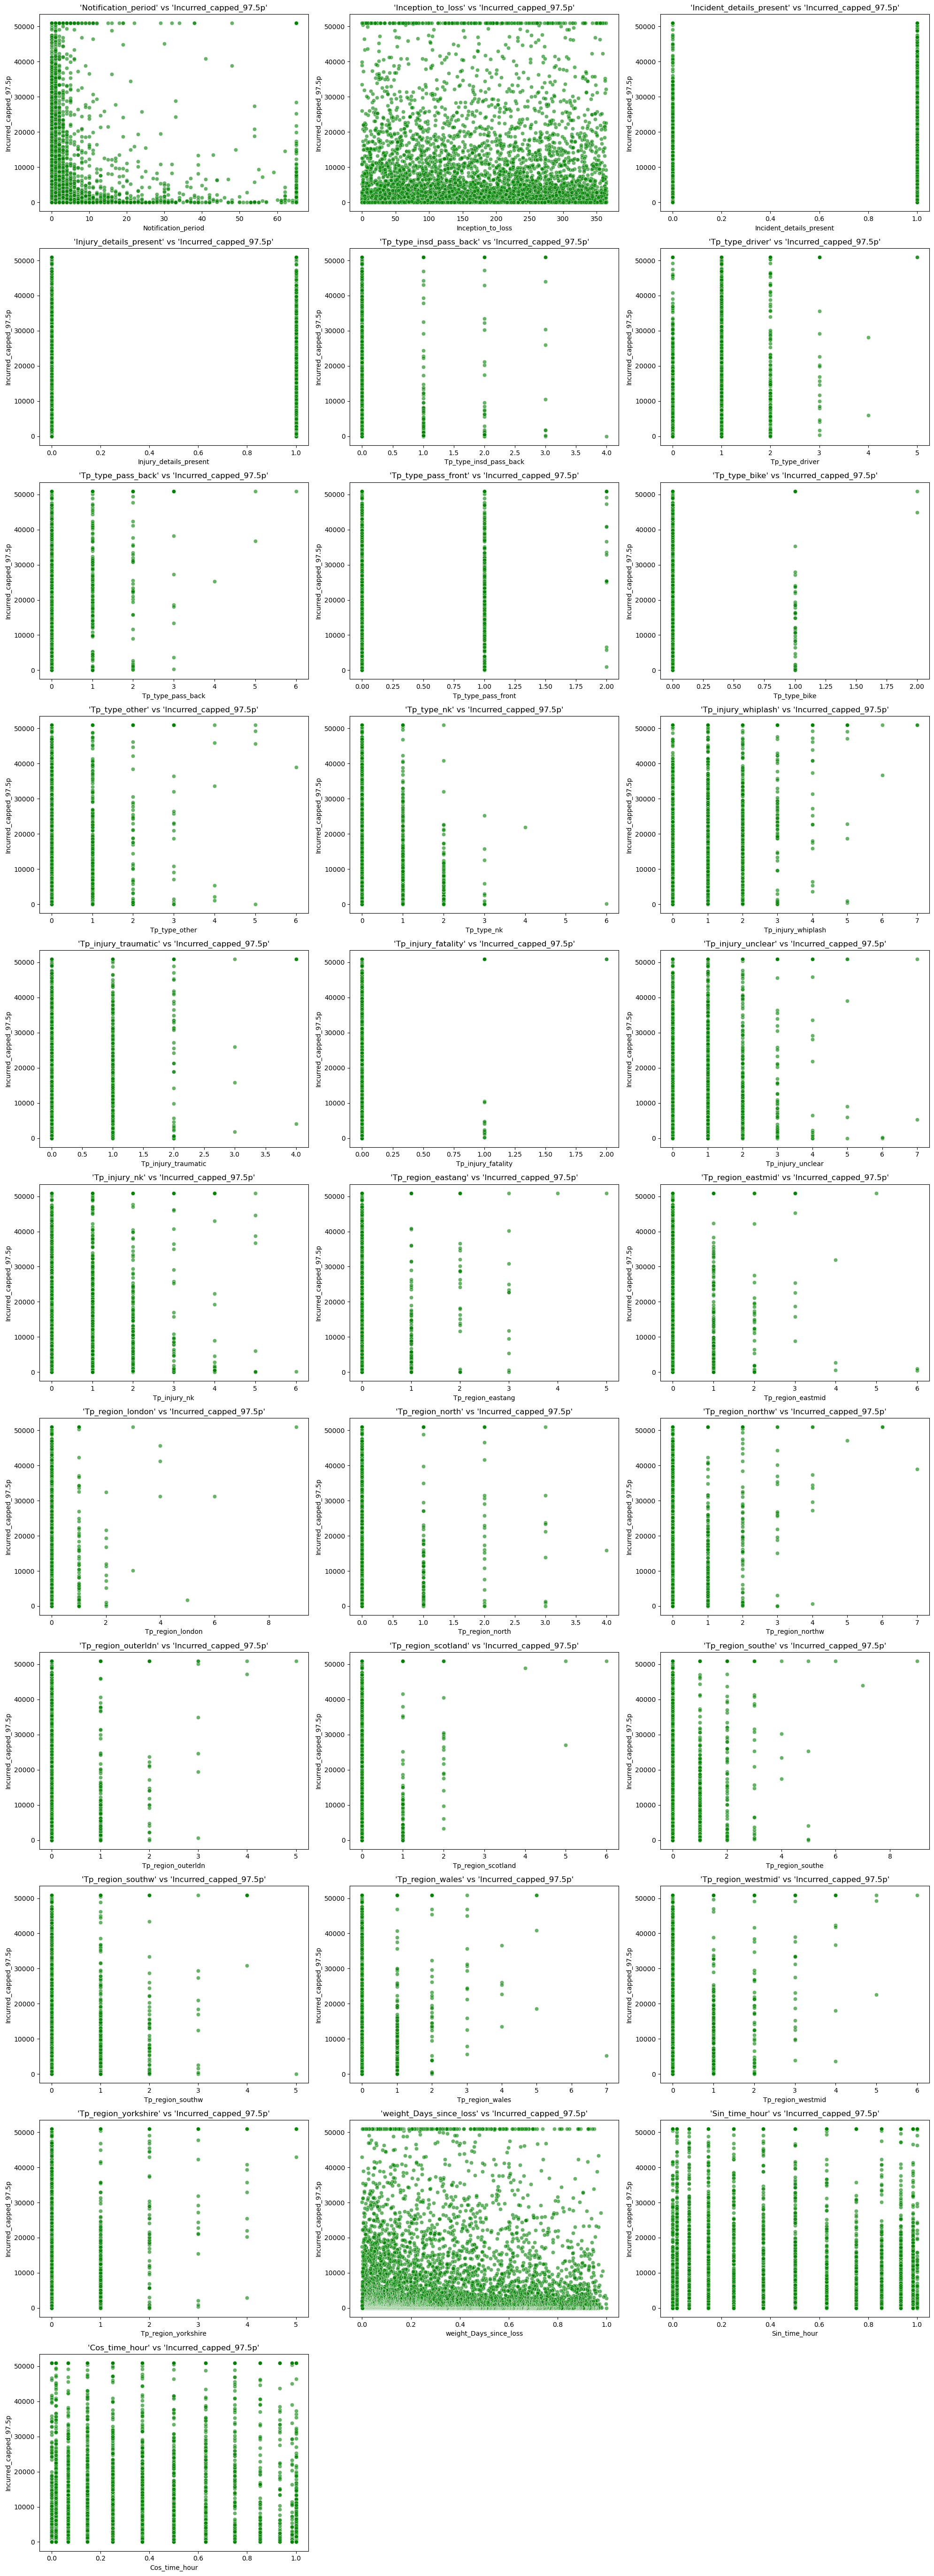

In [24]:
#Scatterplot of numerical features vs target
def plot_numeric_scatterplots(df, target, num_cols = 3, verbose = False):
    """
    Plot scatter plots for all numeric features against the target variable.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the numeric features and the target variable.
    - target (str): The name of the target variable for the scatter plots.
    - num_cols (int): The number of columns for the subplot grid. Default is 3.
    - verbose (bool): If True, prints the list of numeric features.

    Returns:
    - None. The function displays scatter plots of numeric features against the target variable.
    """

    # Select only numeric features, excluding the target variable
    numeric_features = df.select_dtypes(include=['float64', 'int64']).columns.drop(target)

    # Get the number of numeric features
    num_features = len(numeric_features)

    # Calculate the number of rows needed for the subplot grid
    num_rows = -(-num_features // num_cols)  # Ceiling division to determine number of rows

    # Create a figure with subplots for each numeric feature
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 5 * num_rows))

    # Flatten the axes array to easily iterate through subplots
    axes = axes.flatten()

    # Loop through each numeric feature and plot a scatter plot
    for i, feature in enumerate(numeric_features):
        sns.scatterplot(x=df[feature], y=df[target], color='green', alpha=0.6, ax=axes[i])
        axes[i].set_title(f"'{feature}' vs '{target}'")  # Set title for each subplot
        axes[i].set_xlabel(feature)  # Set x-axis label
        axes[i].set_ylabel(target)  # Set y-axis label

    # Remove unused subplots (if any)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust the layout for better spacing
    plt.tight_layout()

    # Display the scatter plots
    plt.show()

# runner:
plot_numeric_scatterplots(df_cleaned, target='Incurred_capped_97.5p', num_cols=3, verbose=True)


#### **Boxplots of Categorical Features vs. the Target Variable**


/var/folders/7w/8shm1yrj4fb4s6llyls0ft600000gp/T/ipykernel_84065/2435754351.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[column], y=df[target], palette='Set2', ax=axes[i])
/var/folders/7w/8shm1yrj4fb4s6llyls0ft600000gp/T/ipykernel_84065/2435754351.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[column], y=df[target], palette='Set2', ax=axes[i])
/var/folders/7w/8shm1yrj4fb4s6llyls0ft600000gp/T/ipykernel_84065/2435754351.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[column], y=df[target], palette='Set2', ax=a

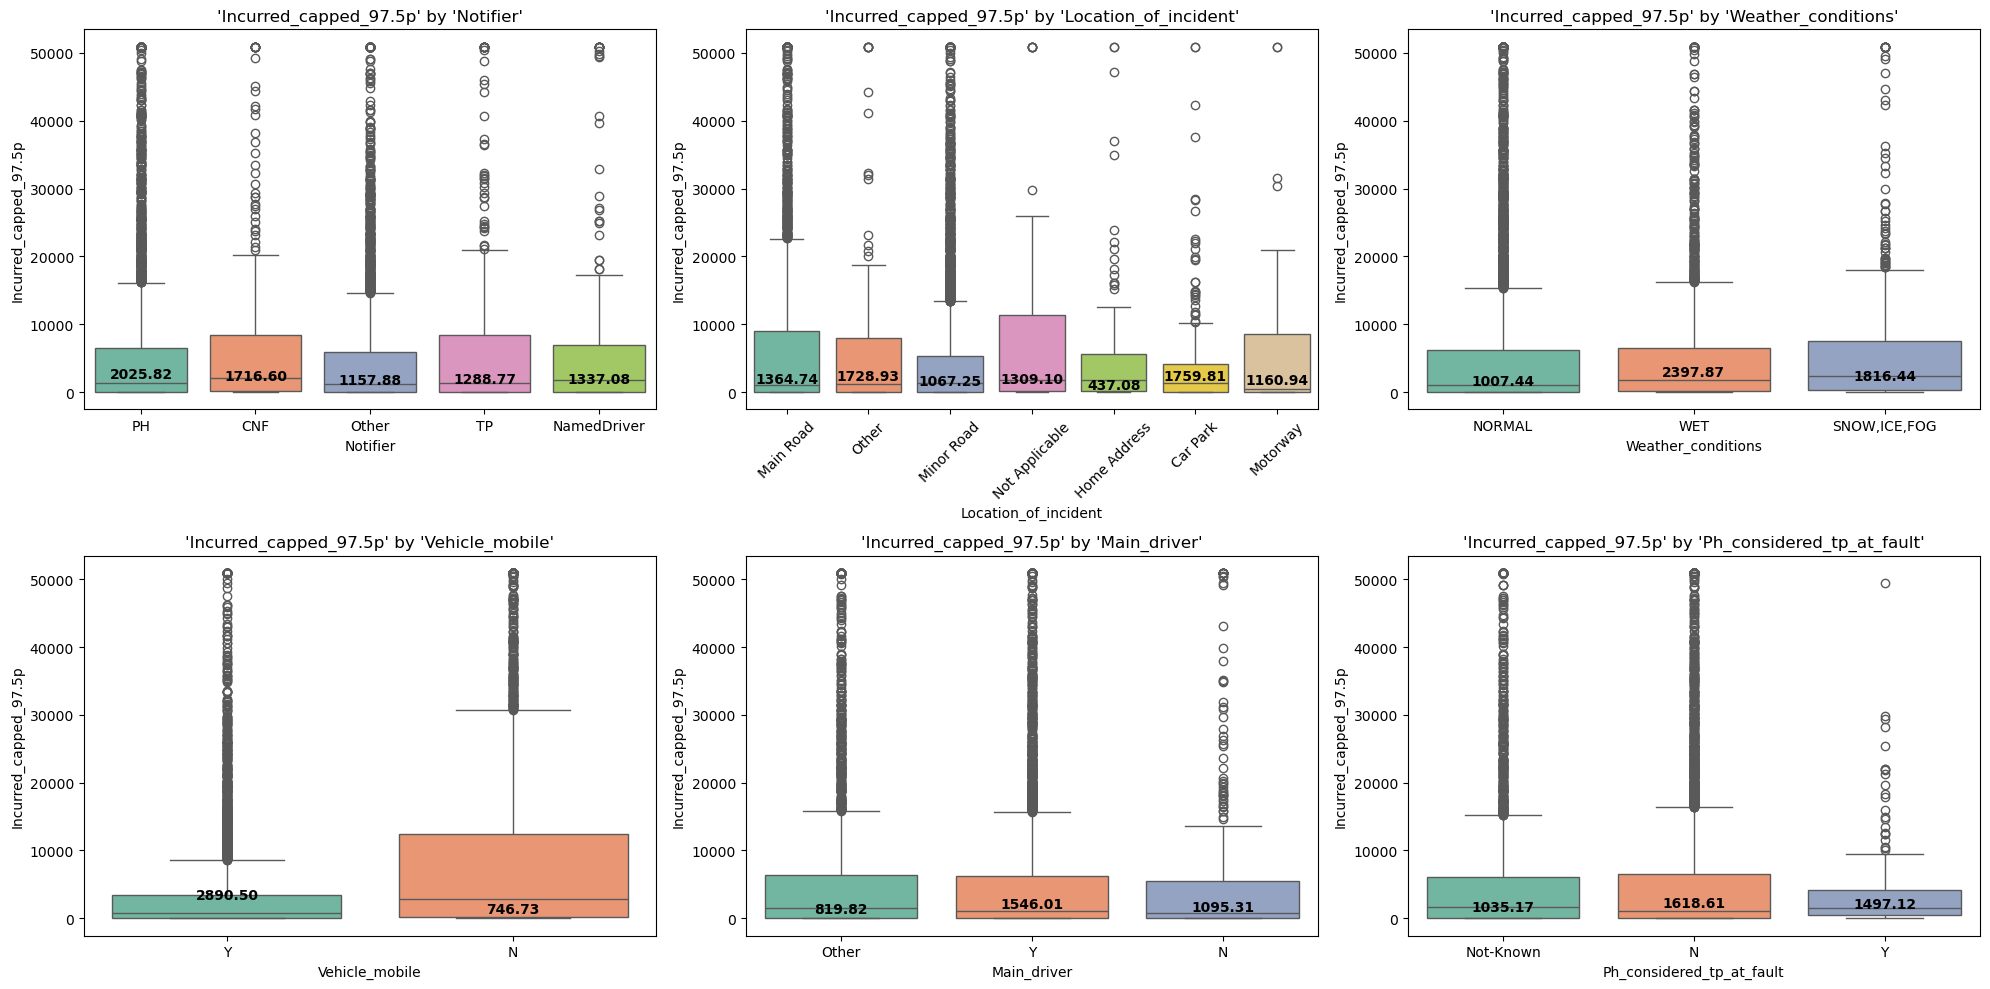

In [26]:
# Boxplots of Categorical Features vs. the Target Variable
def plot_categorical_columns_vs_target(df, target, categorical_columns, num_cols = 3):
    """
    Plots boxplots of the target variable against each categorical column.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - target (str): The name of the continuous target variable.
    - categorical_columns (list): List of categorical column names.
    - num_cols (int): Number of subplot columns per row. Default is 3.

    Returns:
    - None. The function displays boxplots.
    """
    num_features = len(categorical_columns)
    num_rows = -(-num_features // num_cols)  # Ceiling division

    # Create subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 5 * num_rows))
    axes = axes.flatten()

    for i, column in enumerate(categorical_columns):
        # Plot Boxplot
        sns.boxplot(x=df[column], y=df[target], palette='Set2', ax=axes[i])
        axes[i].set_title(f"'{target}' by '{column}'")
        axes[i].set_xlabel(column)
        axes[i].set_ylabel(target)

        # Rotate x-axis labels if necessary
        if df[column].nunique() > 5:
            axes[i].tick_params(axis='x', rotation=45)

        # Optional: Annotate medians
        medians = df.groupby(column)[target].median()
        for tick, median in zip(axes[i].get_xticks(), medians):
            axes[i].text(tick, median, f"{median:.2f}", horizontalalignment='center', color='black', weight='semibold')

    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# runner:
categorical_columns = df_cleaned.select_dtypes(include=['object', 'category']).columns.tolist()  # Extract categorical columns
plot_categorical_columns_vs_target(df_cleaned, target='Incurred_capped_97.5p', categorical_columns=categorical_columns, num_cols=3)



## **Model Specification and Justification**
 
#### **XGBoost Advantages**:  
  - **High Performance**: Fast and accurate for large datasets.  
  - **Regularization**: L1/L2 prevents overfitting.  
  - **Sparse Data Handling**: Natively manages missing data.  
  - **Feature Importance**: Identifies key features for prediction.
    

#### **Model weights, Data Splitting and Encoding**

- **Model weights**: Since recent claims are more important, we use weights in the model by calculating a decay function over the **day_since_loss** feature. This increases the decay effect, ensuring that recent claims are weighted more heavily.
- **Data Splitting**: The data is split into training and testing sets for both the features and the target, along with the sample weights.
- **Encoding Categorical features**: In order to implement XGBoost model we apply **One-hot encoding** on the categorical features. 
  
#### **Target Transformation**

- **Applying Transformations**: 
  - Depending on the nature of the distribution, we either apply a **log transformation** or a **Box-Cox transformation**.
  - The transformation did not improved our model and we used **the origina target variable in our model**. 
  

    


In [28]:
#Split, define sample weight for the model and encode the categorical columns
def prepare_data_for_modeling(df, target, weights, encoding_methods, decay_func=True, split_test_size=0.35, verbose = False):
    """
    Prepares data for modeling by splitting into training and test sets, applying sample weights, and encoding categorical variables.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - target (str): The name of the target variable.
    - weights (str): The name of the column used for sample weighting.
    - encoding_methods (dict): Dictionary specifying encoding methods for categorical columns (e.g., 'onehot', 'label').
    - split_test_size (float): The proportion of the dataset to include in the test split. Default is 0.35.
    - decay_func (bool): If True, applies exponential decay to sample weights. Default is True.
    - verbose (bool): If True, prints missing values and sample weights.

    Returns:
    - X_train, X_test, y_train, y_test, train_weights, test_weights (pd.DataFrames): Training and test sets with features, target, and weights.
    """

    # Create a copy of the DataFrame for modeling
    df_model = df.copy()

    # Define X (features) and y (target)
    X = df_model.drop(columns=[target, weights])  # Drop target and weight columns from feature set
    y = df_model[target]  # Define the target variable

    # Create sample weights by reversing the 'Days_since_loss' weights

    if decay_func:
        # Set an optional decay rate, default is 1 (no decay)
        decay_rate = 0.5  # You can adjust this value (e.g., 0.5, 0.1, etc.) to increase the decay effect
        # Exponentially decay weights so that recent claims are weighted more
        sample_weights = np.exp(-decay_rate * df_model[weights])
    else:
        # Create sample weights by differentiating the 'Days_since_loss' weights from 1 (recent claims are weighted more)
        sample_weights = 1 - df_model[weights]


    # Display the first 10 sample weights if verbose
    if verbose:
        print(sample_weights.head(10))

    # If verbose is enabled, print any missing values in the feature set
    if verbose:
        print("Missing values in features:\n", X.isnull().sum())

    # Split the data into training and testing sets (including features, target, and weights)
    X_train, X_test, y_train, y_test, train_weights, test_weights = train_test_split(
        X, y, sample_weights, test_size=split_test_size, random_state=42
    )

    # Initialize a dictionary to store encoders for each categorical feature
    encoders = {}

    # Loop through the encoding methods and apply them to both training and test sets
    for col, encoding in encoding_methods.items():
        
        if encoding == 'label':
            le = LabelEncoder()
            
            # Apply label encoding and store the encoder for future reference
            X_train[col] = le.fit_transform(X_train[col].astype(str))
            X_test[col] = le.transform(X_test[col].astype(str))
            encoders[col] = le

        elif encoding == 'onehot':
            ohe = OneHotEncoder(sparse_output=False, drop='first')  # Drop the first level to avoid dummy variable trap
            
            # Apply one-hot encoding to both training and testing sets
            X_train_ohe = ohe.fit_transform(X_train[[col]])
            X_test_ohe = ohe.transform(X_test[[col]])
            
            # Convert the one-hot encoded arrays back to DataFrames and merge them with the original sets
            X_train_ohe = pd.DataFrame(X_train_ohe, index=X_train.index, columns=ohe.get_feature_names_out([col]))
            X_test_ohe = pd.DataFrame(X_test_ohe, index=X_test.index, columns=ohe.get_feature_names_out([col]))
            
            # Drop the original column and add the new one-hot encoded columns
            X_train = X_train.drop(columns=[col]).join(X_train_ohe)
            X_test = X_test.drop(columns=[col]).join(X_test_ohe)
            
            encoders[col] = ohe

        else:
            raise ValueError(f"Unknown encoding method: {encoding}")

    # Return the prepared training and testing sets along with the weights
    return X_train, X_test, y_train, y_test, train_weights, test_weights



# runner:
encoding_methods = {
    'Notifier': 'onehot',  
    'Location_of_incident': 'onehot', 
    'Weather_conditions': 'onehot',  
    'Vehicle_mobile': 'onehot',
    'Main_driver': 'onehot',
    'Ph_considered_tp_at_fault': 'onehot'
}

X_train, X_test, y_train, y_test, train_weights, test_weights = prepare_data_for_modeling(
    df_cleaned, target='Incurred_capped_97.5p', weights='weight_Days_since_loss', encoding_methods=encoding_methods, split_test_size=0.35, decay_func=True, verbose=False
)


In [29]:
#target_trnsformation
def target_trnsformation(y_train, y_test, trans_method='none'):
    """
    Parameters:
    - y_train (pd.Series or np.ndarray): The training target values.
    - y_test (pd.Series or np.ndarray): The test target values.
    - trans_method (str): The transformation method to apply to the target ('log', 'boxcox', or 'none').
    
    Returns:
    - y_train_transformed, y_test_transformed (np.ndarray): The transformed target values for training and testing sets.
    """


    # Step 1: Apply log transformation or Box-Cox transformation
    if trans_method == 'log':
        # Apply log1p transformation (log(1 + x)) to handle zero values and skewness
        y_train_transformed = np.log1p(y_train)
        y_test_transformed = np.log1p(y_test)
    
    elif trans_method == 'boxcox':
        # Shift the values to ensure all values are positive before Box-Cox transformation
        shift_value = abs(min(min(y_train), min(y_test))) + 1  # Shift value to make all values positive
        y_train_shifted = y_train + shift_value  # Shifted training set
        y_test_shifted = y_test + shift_value  # Shifted test set

        # Apply Box-Cox transformation
        y_train_transformed, fitted_lambda = boxcox(y_train_shifted)  # Box-Cox for y_train
        y_test_transformed = boxcox(y_test_shifted, lmbda=fitted_lambda)  # Box-Cox for y_test
    
    else:
        # If no transformation is applied, keep the original target values
        y_train_transformed = y_train
        y_test_transformed = y_test


    return y_train_transformed, y_test_transformed

# runner:
y_train_transformed, y_test_transformed = target_trnsformation(y_train, y_test, trans_method=trans_method)


## **Model Specification and Justification**

- **Hyperparameter Tuning**
    - We run the XGBoost model with sample weights. 
    - To find the optimal set of hyperparameters for XGBoost, we use **RandomizedSearchCV**.
    - The best Parameters: {'subsample': 1.0, 'n_estimators': 500, 'min_child_weight': 7, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.5}


In [31]:
#train_xgboost_model, search and find best model and return predictors
def train_xgboost_model(X_train, y_train, train_weights, X_test, param_dist, n_iter=100, scoring='neg_mean_absolute_error', cv=5, verbose=2, random_state=42):
    """
    Trains an XGBoost model with hyperparameter tuning using RandomizedSearchCV, and makes predictions on the test set.

    Parameters:
    - X_train (pd.DataFrame): The training feature set.
    - y_train (pd.Series or np.ndarray): The transformed target variable for training.
    - train_weights (pd.Series or np.ndarray): Sample weights for training.
    - X_test (pd.DataFrame): The test feature set.
    - param_dist (dict): The hyperparameter grid to search for the XGBoost model.
    - n_iter (int): The number of iterations for RandomizedSearchCV (default is 100).
    - scoring (str): The scoring metric for RandomizedSearchCV (default is 'neg_mean_absolute_error').
    - cv (int): The number of cross-validation folds (default is 5).
    - verbose (int): The verbosity level of the search (default is 2).
    - random_state (int): The random state for reproducibility (default is 42).

    Returns:
    - best_xgboost_model (xgb.XGBRegressor): The best XGBoost model found by RandomizedSearchCV.
    - y_pred (np.ndarray): Predictions made by the best model on the test set.
    """

    # Define the XGBoost model
    xgboost_model = xgb.XGBRegressor(random_state=random_state)

    # Perform hyperparameter tuning with RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=xgboost_model,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring=scoring,
        cv=cv,
        verbose=verbose,
        random_state=random_state,
        n_jobs=-1
    )

    # Fit the model on the training data with sample weights
    random_search.fit(X_train, y_train, sample_weight=train_weights)

    # Output the best parameters and best score from RandomizedSearchCV
    print("[DEBUG] - Best Parameters:", random_search.best_params_)
    print("[DEBUG] - Best CV Score (neg MAE):", random_search.best_score_)

    # Extract the best model from RandomizedSearchCV
    best_xgboost_model = random_search.best_estimator_

    # Make predictions on the test set using the best model
    y_pred = best_xgboost_model.predict(X_test)

    return best_xgboost_model, y_pred

# runner:

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 500, 700],          # Number of trees
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],      # Learning rate
    'max_depth': [4, 6, 8, 10, 14, 20],                # Maximum depth of trees
    'min_child_weight': [1, 3, 5, 7],                  # Minimum sum of instance weight
    'subsample': [0.5, 0.8, 1.0],                     # Fraction of samples to be used for training
    'colsample_bytree': [0.5, 0.8, 1.0]               # Fraction of features used per tree
}

# keep a copy of the original X_train and X_test
X_train_reduced =X_train.copy()
X_test_reduced = X_test.copy()

# Train the XGBoost model with hyperparameter tuning
best_xgboost_model, y_pred_transformed = train_xgboost_model(
    X_train_reduced, 
    y_train_transformed, 
    train_weights, 
    X_test_reduced, 
    param_dist, 
    n_iter=100, 
    scoring='neg_mean_absolute_error', 
    cv=5, 
    verbose=1, 
    random_state=42
)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[DEBUG] - Best Parameters: {'subsample': 1.0, 'n_estimators': 500, 'min_child_weight': 7, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.5}
[DEBUG] - Best CV Score (neg MAE): -2.5663564239919308


## **Model Accuracy and Diagnostics**

#### - Mean Absolute Error (MAE):
The Mean Absolute Error (MAE) of the model is approximately 4660

#### - Residual Distribution Plot:
- the residuals should be centered around zero and follow a normal distribution, indicating that the model's predictions are unbiased and that it has adequately captured the data patterns.
- Any significant deviations from this normal distribution may signal potential issues, such as **heteroscedasticity** or the presence of outliers, highlighting areas where model improvements may be necessary.

#### - Check overfitting
- We use Mean Absolute Error (MAE) to evaluate performance on both training and validation sets for different max-depth

R² Score after log transformation: 0.0015930283655197774
Mean Absolute Error (MAE): 5172.875492913144
Mean Squared Error (MSE): 131156051.06421117
Root Mean Squared Error (RMSE): 11452.338235670966
                                Feature  Importance
11                   Tp_injury_whiplash    0.155362
7                    Tp_type_pass_front    0.111990
42                     Vehicle_mobile_Y    0.097783
14                    Tp_injury_unclear    0.075522
12                  Tp_injury_traumatic    0.056160
9                         Tp_type_other    0.055667
6                     Tp_type_pass_back    0.052955
15                         Tp_injury_nk    0.024971
45  Ph_considered_tp_at_fault_Not-Known    0.023897
5                        Tp_type_driver    0.020938
10                           Tp_type_nk    0.019006
40      Weather_conditions_SNOW,ICE,FOG    0.014643
46          Ph_considered_tp_at_fault_Y    0.014274
41               Weather_conditions_WET    0.014044
33                    

/var/folders/7w/8shm1yrj4fb4s6llyls0ft600000gp/T/ipykernel_84065/1154035667.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


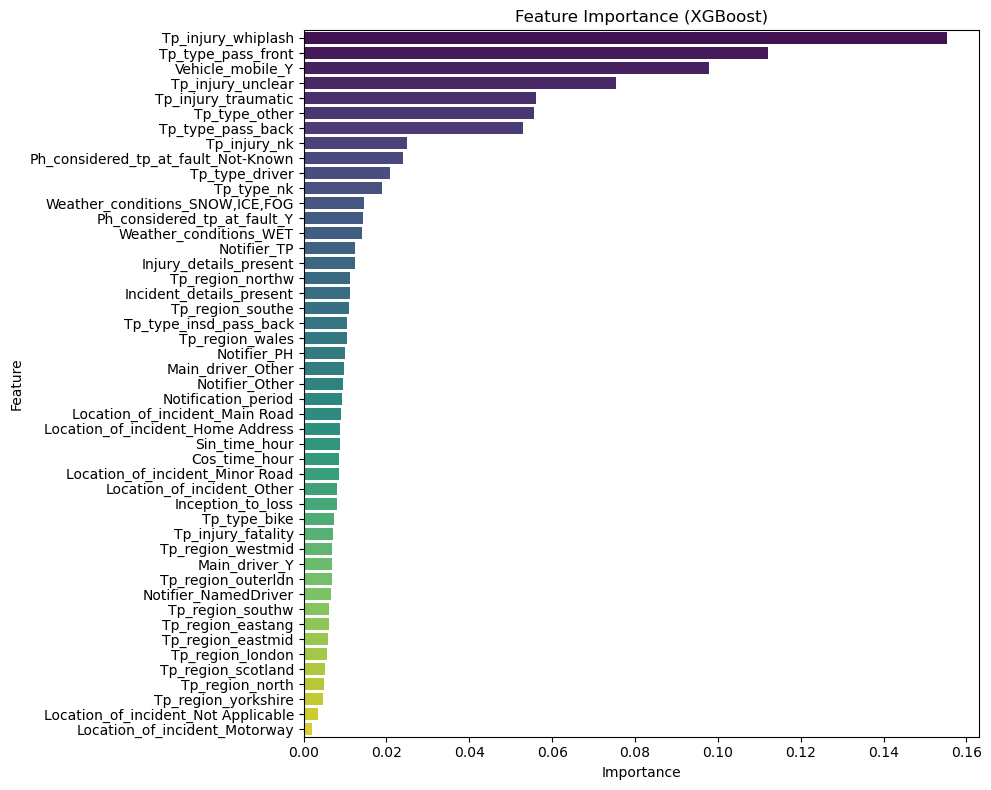

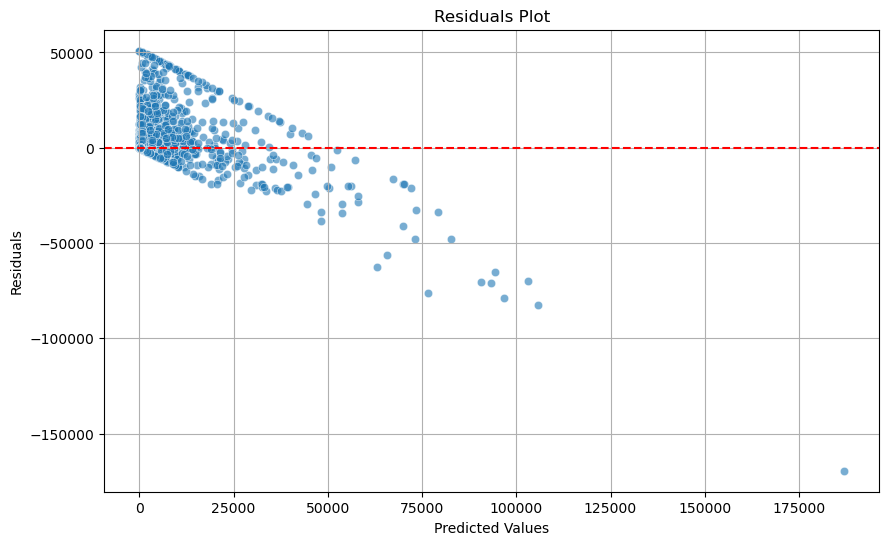

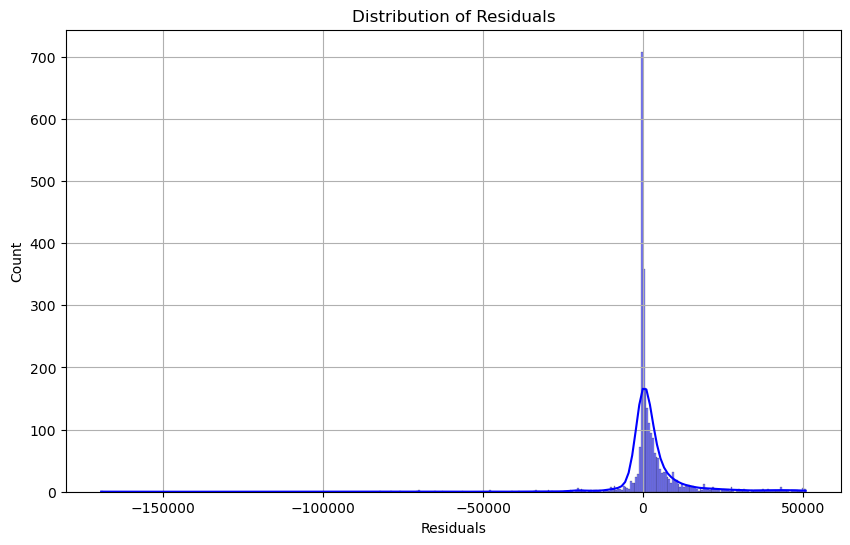

Model and parameters saved to /Users/saeideh/job_seek/Data_Science/UK_2024/Oct2024/Job_application/Interview/Task/Hastings_direct_task/task_info/model/best_model.pkl


In [40]:
#Evaluation
def evaluate_model_and_save(
    y_test, y_pred_transformed, best_model, X_train, trans_method='none', 
    fitted_lambda=None, shift_value=0, model_save_path='best_model.pkl'):
    """
    Evaluates the model's performance by calculating R², MAE, and RMSE, and optionally reverses transformations on the predictions.
    Additionally, it calculates and plots residuals, and saves the model and transformation parameters in a pickle file.

    Parameters:
    - y_test (pd.Series or np.ndarray): The original target values from the test set.
    - y_pred_transformed (np.ndarray): The predicted values after transformation.
    - best_model: The best model (e.g., XGBoost) used for feature importance extraction.
    - X_train (pd.DataFrame): The training feature set used to get the feature names.
    - trans_method (str): The transformation method used ('log', 'boxcox', or 'none').
    - fitted_lambda (float): The lambda parameter for Box-Cox transformation (required if `boxcox` is used).
    - shift_value (float): The shift value used for the Box-Cox transformation (required if `boxcox` is used).
    - model_save_path (str): The file path where the best model and associated parameters will be saved.

    Returns:
    - metrics (dict): A dictionary containing R², MAE, MSE, and RMSE values.
    - feature_importance_df (pd.DataFrame): A DataFrame of feature importances.
    """

    # Reverse the transformation on the predictions (if necessary)
    if trans_method == 'log':
        y_pred = np.expm1(y_pred_transformed)  # Inverse log transformation
    elif trans_method == 'boxcox':
        y_pred_shifted = inv_boxcox(y_pred_transformed, fitted_lambda)  # Inverse Box-Cox transformation
        y_pred = y_pred_shifted - shift_value
    else:
        y_pred = y_pred_transformed

    # Calculate R² score
    r2 = r2_score(y_test, y_pred)
    print(f"R² Score after {trans_method} transformation: {r2}")

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    # Print evaluation metrics
    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)

    # Get feature importances from the model
    importances = best_model.feature_importances_

    # Create a DataFrame for feature importance
    feature_importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Print the most important features
    print(feature_importance_df)

    # Plot feature importance
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
    plt.title('Feature Importance (XGBoost)')
    plt.tight_layout()
    plt.show()

    # Calculate residuals
    residuals = y_test - y_pred

    # Plot residuals scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
    plt.axhline(0, color='r', linestyle='--')  # Add a horizontal line at 0 for reference
    plt.title('Residuals Plot')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.show()

    # Plot the distribution of residuals
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True, color='blue')
    plt.title('Distribution of Residuals')
    plt.xlabel('Residuals')
    plt.grid(True)
    plt.show()

    # Save the model and parameters
    metrics = {
        'R²': r2,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse
    }

    # Ensure the model subdirectory exists
    os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

    # Save the best model and transformation parameters to a pickle file
    model_data = {
        'best_model': best_model,
        'feature_names': X_train.columns.tolist(),
        'trans_method': trans_method,
        'fitted_lambda': fitted_lambda,
        'shift_value': shift_value
    }

    with open(model_save_path, 'wb') as f:
        pickle.dump(model_data, f)
    
    print(f"Model and parameters saved to {model_save_path}")

    return metrics, feature_importance_df

# runner:
metrics, feature_importance_df = evaluate_model_and_save(
    y_test, y_pred_transformed, best_xgboost_model, X_train_reduced, trans_method=trans_method, 
    fitted_lambda=None, shift_value=0, 
    model_save_path='/Users/saeideh/project/model/best_model.pkl'

)





In [ ]:
#### Visualising the MAE for train and test data, for different max depth

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:47<00:00,  3.34s/it]


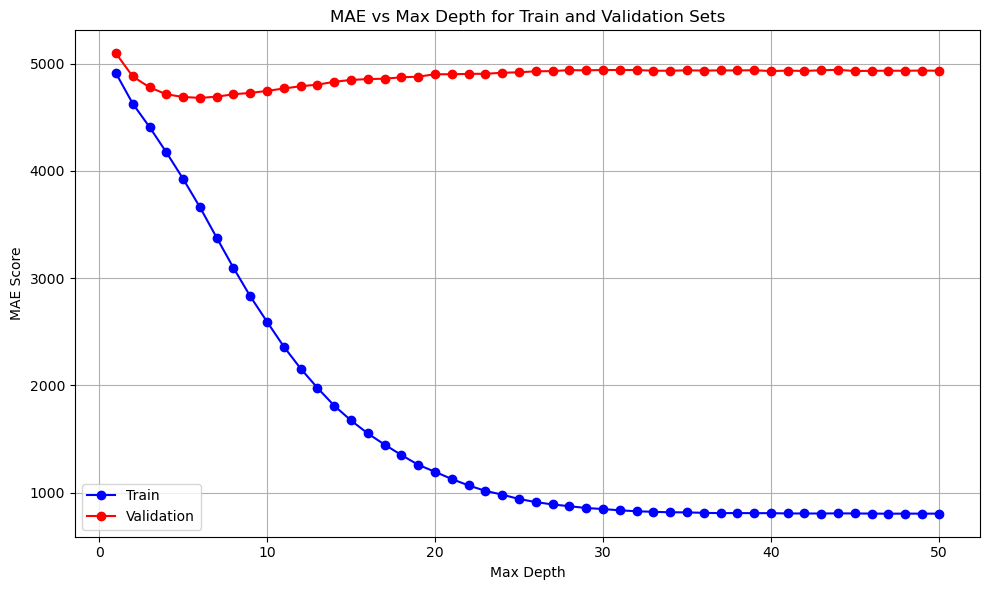

In [44]:
def evaluate_max_depth(X_train, y_train, X_test, y_test, list_depths=np.arange(1, 51)):
    """
    Evaluates the performance of an XGBoost model over a range of max_depth values by calculating MAE for both training and validation sets.

    Parameters:
    - X_train (pd.DataFrame): The training feature set.
    - y_train (pd.Series or np.ndarray): The target values for the training set.
    - X_test (pd.DataFrame): The test feature set.
    - y_test (pd.Series or np.ndarray): The target values for the test set.
    - list_depths (np.ndarray): The range of max_depth values to evaluate (default is 1 to 50).

    Returns:
    - lis_cv_score_train, lis_cv_score_test (list): Lists of MAE scores for training and validation sets.
    """

    # Lists to store MAE scores for training and validation sets
    lis_cv_score_train = []
    lis_cv_score_test = []

    # Loop through different max_depth values to evaluate model performance
    for depth in tqdm(list_depths):  # tqdm used for progress tracking
        # Define the parameters for XGBoost
        params = {
            'colsample_bytree': 0.5,
            'subsample': 0.5,
            'learning_rate': 0.01,
            'max_depth': depth,  # Max depth changes in each iteration
            'min_child_weight': 1,
            'objective': 'reg:squarederror',  # Regression objective
            'seed': 2016  # Random seed for reproducibility
        }

        # Initialize the XGBRegressor with the current set of parameters
        xgb_model = xgb.XGBRegressor(**params, n_estimators=700, random_state=2016)
        
        # Fit the model on the training set
        xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)  # Train without verbose output
        
        # Evaluate on the training set
        y_train_pred = xgb_model.predict(X_train)
        cv_score_train = mean_absolute_error(y_train, y_train_pred)  # Calculate MAE for training set
        lis_cv_score_train.append(cv_score_train)  # Append MAE score
        
        # Evaluate on the validation (test) set
        y_test_pred = xgb_model.predict(X_test)
        cv_score_test = mean_absolute_error(y_test, y_test_pred)  # Calculate MAE for validation set
        lis_cv_score_test.append(cv_score_test)  # Append MAE score

    # Plot the results of training and validation MAE scores
    plt.figure(figsize=(10, 6))
    plt.plot(list_depths, lis_cv_score_train, label="Train", marker='o', color='blue')  # Training set MAE
    plt.plot(list_depths, lis_cv_score_test, label="Validation", marker='o', color='red')  # Validation set MAE
    plt.xlabel("Max Depth")  # x-axis label
    plt.ylabel("MAE Score")  # y-axis label
    plt.title("MAE vs Max Depth for Train and Validation Sets")  # Plot title
    plt.legend()  # Show legend
    plt.grid(True)  # Enable grid for better readability
    plt.tight_layout()  # Adjust layout
    plt.show()  # Display the plot

    return lis_cv_score_train, lis_cv_score_test

# runner:
list_depths = np.arange(1, 51)  # Define the range of max_depth values to try
lis_cv_score_train, lis_cv_score_test = evaluate_max_depth(X_train, y_train, X_test, y_test, list_depths=list_depths)


#### Model Deployment

In [ ]:
#Model deployment
def preprocess_new_data(new_data, encoding_methods, columns_to_drop=None):
    """
    Applies all the necessary preprocessing steps to the new test data before deploying the model.
    This function mirrors the preprocessing performed on the training data, including cleaning, handling missing values, 
    dropping unnecessary columns, and encoding categorical variables.

    Parameters:
    - new_data (pd.DataFrame): The new test data to preprocess.
    - encoding_methods (dict): Dictionary specifying encoding methods for categorical columns (e.g., 'onehot', 'label').
    - columns_to_drop (list, optional): List of columns to drop from the dataset, including unnecessary features or target variables.

    Returns:
    - new_data (pd.DataFrame): The preprocessed data ready for the model.
    """

    # Step 1: General preprocessing (e.g., basic cleaning) similar to the training phase
    new_data = preprocess_dataset(new_data)

    # Step 2: Clean and fill missing values
    new_data = clean_and_fill_missing_values(new_data)

    # Step 3: Drop unnecessary columns (e.g., target variables and irrelevant features)
    if columns_to_drop is not None:
        # Drop specified columns and update the numeric variables list
        new_data, _ = drop_columns_and_update_numeric_vars(new_data, columns_to_drop, verbose=False)
    
    # Step 4: Automatically drop columns containing 'Incurred' (case-insensitive)
    columns_to_drop = [col for col in new_data.columns if 'incurred' in col.lower()]

    # Also drop the 'weight_Days_since_loss' column used during training
    columns_to_drop.append('weight_Days_since_loss')

    # Get the list of numeric variables (features with float64 or int64 data types)
    numeric_vars = new_data.select_dtypes(include=['float64', 'int64']).columns.tolist()

    # Drop the identified columns and update numeric variables accordingly
    new_data, numeric_vars = drop_columns_and_update_numeric_vars(new_data, columns_to_drop, verbose=False)

    # Step 5: Handle missing values, outliers, and clean numeric columns
    new_data = clean_numerical_data(new_data, numeric_vars, plot=False)

    # Step 6: Apply encoding to categorical columns
    encoders = {}

    for col, encoding in encoding_methods.items():
        if encoding == 'label':
            # Apply label encoding to categorical columns
            le = LabelEncoder()
            new_data[col] = le.fit_transform(new_data[col].astype(str))
            encoders[col] = le
        elif encoding == 'onehot':
            # Apply one-hot encoding to categorical columns
            ohe = OneHotEncoder(sparse_output=False, drop='first')  # Drop first to avoid dummy variable trap
            new_data_ohe = ohe.fit_transform(new_data[[col]])
            new_data_ohe = pd.DataFrame(new_data_ohe, index=new_data.index, columns=ohe.get_feature_names_out([col]))
            new_data = new_data.drop(columns=[col]).join(new_data_ohe)
            encoders[col] = ohe
        else:
            # Raise an error if an unknown encoding method is provided
            raise ValueError(f"Unknown encoding method: {encoding}")

    return new_data

# runner:
# encoding_methods = {
#     'Notifier': 'onehot',  
#     'Location_of_incident': 'onehot', 
#     'Weather_conditions': 'onehot',  
#     'Vehicle_mobile': 'onehot',
#     'Main_driver': 'onehot',
#     'Ph_considered_tp_at_fault': 'onehot'
# }

# # Example columns to drop (e.g., target or unnecessary columns)
# columns_to_drop = ['Claim_number', 'Incurred', 'Vechile_registration_present', 'Tp_type_cyclist', 'Tp_type_pedestrian']

# # Preprocess the new test data
# preprocessed_data = preprocess_new_data(new_data, encoding_methods, columns_to_drop=columns_to_drop)



## **Suggestions for Model Improvement**

#### - More Data:
   - Collecting and incorporating **more recent claim data** to ensure that the model remains up to date with current patterns.
   - Enriching the feature set by integrating **external data sources** (e.g., weather, socioeconomic data).

#### - Feature Engineering Enhancements:
   - Creating more **time-related features** (e.g., weekends, day of the week, month, or seasonality) to capture any temporal patterns in the data.
   - Creating **interaction features** between existing variables (e.g., combining time-based and categorical features) to uncover deeper relationships.

#### - Feature Selection:
   - Using feature selection techniques like **L1 regularization (Lasso)** or **Recursive Feature Elimination (RFE)**.
   - Utilizing feature importance scores from **tree-based models** to remove irrelevant features and improve model simplicity.

#### - Advanced Methods for Handling Missing Data:
   - Applying multiple imputation methods such as **K-Nearest Neighbors (KNN) Imputation** or **Multiple Imputation** to fill in missing data.
   - Using deep learning techniques like **autoencoders** for robust missing data imputation.

#### - Handling Skewed Target:
   - Both **log transformation** and **Box-Cox transformation** were applied, but neither significantly improved the model’s performance. Exploring alternative approaches such as **quantile regression** or **robust models** specifically designed for skewed data could be more effective.
   - Applying **weighted loss functions** to ensure that large claims receive more attention in the model, helping to mitigate the impact of skewness on predictive accuracy.
     
#### - Hyperparameter Improvement:
   - Exploring **a wider range** of hyperparameters
   - Further **optimization techniques** by exploring more advanced techniques like **Bayesian optimization** or **grid search** 

#### - Hybrid approach (combining Different Modeling Approaches):
   - While **XGBoost** has been used effectively, combining it with other GBM models, **LightGBM** and **CatBoost** or other ML methods like **Random Forest** or **Neural Networks** can further enhance performance by capturing different patterns in the data.

#### - Custom Loss Functions:
   - **Weighted Loss Functions**: Defining a custom loss function aligned with the business problem, such as penalizing underestimations of large claims more heavily than overestimations.
   - Implementing **quantile regression** to predict different percentiles of the target variable, rather than just focusing on the mean.

#### - Utilizing Probability Distribution Theory:
- **Modeling claim arrivals** using a Poisson distribution and waiting times between claims with an exponential distribution could uncover further relationships between the frequency and timing of claims, helping optimize risk assessment and resource allocation.

#### - Model Monitoring and Maintenance:
   - Continuously monitoring performance metrics like **Mean Absolute Error (MAE)**, and setting alerts for any significant deviations.
   - Implementing real-time monitoring for **data drift** and **concept drift**, with automated retraining mechanisms to keep the model updated as the data evolves.


## **Practical Challenges in Model Implementation**

#### - Lack of Business Information:
- **For Defining Loss**: Insufficient business context makes it challenging to accurately define evaluation metrics for model performance that align with business objectives.
- **For Handling "N/K" Values**: Dealing with missing or "N/K" (Not Known) values is difficult without sufficient business information, making it hard to determine the most appropriate imputation strategy.

#### - Small Dataset:
- The **small size of the dataset** limited the model's exposure to variability in the data, increasing the risk of overfitting or underfitting. This also made it harder to validate the model's generalization and performance.

#### - Skewed Target and Imbalanced Features:
- The target variable (claims) was highly **skewed**, and some features in the dataset are **imbalanced**, which can lead to biased predictions and challenges in modeling accurately.
- **Model Evaluation**: The skewed target and imbalanced features, combined with a small dataset, made it difficult to evaluate the model. The resulting **MAE** metric may not fully capture model performance, and it was unclear whether the **MAE** was good enough for the business problem.

#### - Heteroscedasticity in Residuals:
- The residual plot showed signs of **heteroscedasticity**, with both underestimations and overestimations present.

#### - Handling "N/K" Values:
- Dealing with **missing or "N/K" (Not Known)** values without sufficient business information creates uncertainty in selecting appropriate strategies, which can affect the model’s reliability.

#### - Difficulty in Model Interpretability:
- The complexity of the **XGBoost model** makes it challenging for stakeholders to understand and interpret predictions. Ensuring transparency in the model’s decisions is difficult, especially in a business context where interpretability is critical.

#### - Model deployment: 
- Over time, the underlying data distribution may change (e.g., new types of claims), causing the model to lose accuracy. 